# 教師データファイルの解凍

In [30]:
%%bash

7z x -tzip -y data14.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 2406017 bytes (2350 KiB)

Extracting archive: data14.zip
--
Path = data14.zip
Type = zip
Physical Size = 2406017

Everything is Ok

Folders: 3
Files: 492
Size:       2394245
Compressed: 2406017


# モジュールのインポート

In [31]:
!pip install japanize_matplotlib

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import ReLU, Activation, Dropout, LeakyReLU, Flatten, Concatenate
from tensorflow.keras.layers import RandomFlip
import matplotlib.pyplot as plt
import japanize_matplotlib
import PIL.Image
# tf.config.run_functions_eagerly(True)

# 関数 save_fig：図の保存

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.2)

# 関数 generate_images：学習過程の生成画像を保存

In [33]:
import os
ODIR = 'results'
os.makedirs(ODIR, exist_ok=True)

def generate_images(model, epoch, test_z):
    rows = 4
    cols = 4

    samples = model(test_z, training=False)
    output = []
    for i in range(rows):
        buff = np.concatenate(samples[i * cols:(i+1)*cols], axis=1)
        output.append(buff)

    output = (np.concatenate(output, axis=0) * 127.5 + 127.5).astype('uint8')
    output_image = PIL.Image.fromarray(output)
    output_image.save(os.path.join(ODIR, f'image_at_epoch_{epoch:04d}.png'))

# 実習14.1：Pythonのクラスと```__call__```関数

In [34]:
class Student:
    def __init__(self, name):
        """初期化メソッド。
        Args:
            name (str): 名前
        """
        self.name=name # インスタンス変数に代入
    def __call__(self, message):
        """初期化メソッド。
        Args:
            message (str): 名前
        """
        print(message+self.name+'さん')

s1=Student('情報太郎') # 1個目のStudentクラスインスタンスを生成
s1('こんにちは') # インスタンスs1の__call__メソッドを利用

s2=Student('北海道子') # 2個目のStudentクラスインスタンスを生成
s2('おはよう') # インスタンスs2の__call__メソッドを利用

こんにちは情報太郎さん
おはよう北海道子さん


# 実習14.2：画像ファイルリスト作成と定数定義

In [35]:
import glob

# 解凍した教師データのフォルダ以下にあるjpgファイル一覧を取得
file_list=glob.glob('data14/Training/Apple Red 2/**/*.jpg',recursive=True)
print('画像枚数:',len(file_list))

# バッチサイズ
batch_size=16

#エポック数
num_epochs=400

# 潜在ベクトル次元数
zdim=128

画像枚数: 492


# 実習14.3：画像データセットクラスの定義とインスタンス生成

ステップ数: 30
教師データの形状: (16, 96, 96, 3)


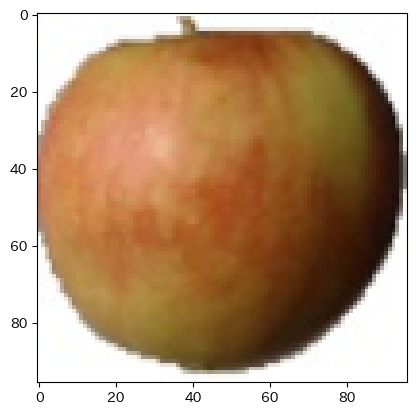

In [36]:
class ImageDataset(Sequence):
    def __init__(self, file_list,batch_size):
        self.file_list=file_list # jpgファイルのパスを格納したリスト
        self.batch_size=batch_size # バッチサイズ

    def __len__(self):
        """1エポック分のステップ数を取得する。
        Returns:
            1エポック分のステップ数
        """
        return len(self.file_list) // self.batch_size
    def __getitem__(self,index):
        """バッチサイズ分の画像を取得する。
        Args:
            index (int): ステップ番号
        Returns:
            指定されたステップ番号で使用する画像
        """
        # 指定されたステップ番号で読み込むファイルのパス
        files=self.file_list[self.batch_size * index : self.batch_size * (index+1)]
        images=[] # 画像を格納するリスト
        for f in files:
            image=PIL.Image.open(f) # 画像の読み込み
            image=image.resize((96,96)) # 96x96にリサイズ
            image=image.convert('RGB') # 色形式をRGBに変換
            image=np.array(image) # NumPy配列へ変換
            # 画素値の範囲を[0,255]から[-1,1]への変換処理
            image=image-127.5 # [0,255]から[-127.5,127.5]への変換
            image=image/127.5 # [-127.5,127.5]から[-1,1]への変換
            # (画像番号、高さ、幅、チャネル)の4次元配列へ変換
            image=image.reshape((1,96,96,3))
            images.append(image) # リストへ画像を追加
        # （バッチサイズ、96、96、3）の形状の配列へ変換後に返却
        return np.concatenate(images,axis=0).astype('float32')
# クラス定義の外。ImageDatasetクラスのインスタンスの生成
dataset=ImageDataset(file_list,batch_size)

print('ステップ数:',len(dataset))
images=dataset[0] # ステップ番号0の画像を取り出す
print("教師データの形状:",images.shape)

# 最初の画像を表示。画素値の範囲を表示のため[-1,1]から[0,1]へ変換
plt.imshow((images[0]+1)*0.5)
plt.show()

# 実習14.4：生成器の定義と生成

In [37]:
def make_Gblock(x,filters,kernel_size,strides):
    """同じ構造を持つ層のあつまり（ブロック）への入力を処理する。
    Args:
        x: ブロックへの入力
        filters: 転置畳み込み層のフィルタ数
        kernel_size: 転置畳み込みのカーネルサイズ
        strides: 転置畳み込みのストライド
    Returns:
        ブロックからの出力
    """
    # 転置畳み込み。バイアスは使用（学習）しない
    x=Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,use_bias=False)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)
    return x
def make_G(zdim):
    """生成器を定義する。
    Args:
        zdim: 潜在ベクトルの次元数
    Returns:
        生成器
    """
    # 1個の潜在ベクトルを高さ1、幅1、チャネル数zdimの画像として生成器に入力する。
    # 生成器への入力サイズを入力層に教える。
    inputs=Input(shape=(1,1,zdim))
    x=make_Gblock(inputs,256,4,1)
    x=make_Gblock(x,128,4,2)
    x=make_Gblock(x,64,4,2)
    x=make_Gblock(x,32,5,2)

    x=Conv2DTranspose(filters=3,kernel_size=4,strides=2,use_bias=False)(x)
    outputs=Activation('tanh')(x) # 出力層の活性化関数
    model=Model(inputs=inputs,outputs=outputs)
    return model

# 関数の外。生成器の生成
G=make_G(zdim)
G.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 256)        524288    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 10, 10, 128)      524288    
 ranspose)                                                       
                                                           

# 実習14.5：識別器の定義と生成

In [38]:
def make_Dblock(x,filters,kernel_size,strides,use_bn=True):
    """同じ構造を持つ層のあつまり（ブロック）への入力を処理する。
    Args:
        x: ブロックへの入力
        filters: 転置畳み込み層のフィルタ数
        kernel_size: 転置畳み込みのカーネルサイズ
        strides: 転置畳み込みのストライド
        use_bn: バッチ正規化を使うか否か
    Returns:
        ブロックからの出力
    """
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides)(x)
    if use_bn:
        x=BatchNormalization()(x)
    x=LeakyReLU(0.1)(x)
    x=Dropout(rate=0.2)(x)
    return x
def make_D(zdim):
    """識別器を定義する。
    Args:
        zdim: 潜在ベクトルの次元数
    Returns:
        生成器
    """
    # 1個の画像のサイズは高さ96、幅96、チャネル数3。
    # 識別器への入力サイズ（1枚の画像サイズ）を入力層に教える。
    inputs=Input(shape=(96,96,3))
    x=RandomFlip(mode='horizontal')(inputs) # データ拡張。左右反転
    x=make_Dblock(x,32,4,2,False)
    x=make_Dblock(x,64,4,2)
    x=make_Dblock(x,128,4,2)
    x=make_Dblock(x,256,4,2)
    x=Conv2D(filters=256,kernel_size=4,strides=1)(x)
    x=Dense(units=1)(x)
    outputs=Activation('sigmoid')(x) # 出力層の活性化関数
    model=Model(inputs=inputs,outputs=outputs)
    return model

# 関数の外。生成器の生成
D=make_D(zdim)
D.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 96, 96, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 32)        1568      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 47, 47, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 64)        32832     
                                                                 
 batch_normalization_14 (Bat  (None, 22, 22, 64)       256 

# 実習14.6：生成器用の損失関数


In [39]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy=BinaryCrossentropy() # 2クラス分類用交差エントロピー誤差

def G_loss_func(fake_pred):
    """生成器用の損失関数
    Args:
        fake_pred: 識別器が生成画像(fake)を本物と予測した確率
    Returns:
        損失
    """
    # 本物であることを示すクラスラベル
    real_labels=tf.ones_like(fake_pred)
    # 生成器にとっては自分が生成した画像を、識別器に本物だと騙せると損失は小さくなる。
    return cross_entropy(real_labels,fake_pred)
# 関数の外。G_loss_funcのテスト
# 識別器が生成画像(fake)を本物と予測した確率が0、識別器に生成画像が偽物と見破られた場合
print('すべて偽物と判定された場合')
fake_pred=tf.zeros((batch_size,1),dtype='float32')
print('fake_pred:',fake_pred)
value=G_loss_func(fake_pred)
print('損失:',value)

# 識別器が生成画像(fake)を本物と予測した確率がすべて1、識別器に生成画像が本物だと騙せた場合
print('すべて本物と判定された場合')
fake_pred=tf.ones((batch_size,1),dtype='float32')
print(fake_pred)
value=G_loss_func(fake_pred)
print('損失:',value)

すべて偽物と判定された場合
fake_pred: tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(16, 1), dtype=float32)
損失: tf.Tensor(15.424949, shape=(), dtype=float32)
すべて本物と判定された場合
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(16, 1), dtype=float32)
損失: tf.Tensor(-0.0, shape=(), dtype=float32)


# 実習14.7：識別器用の損失関数

In [40]:
def D_loss_func(real_pred,fake_pred):
    """識別器用の損失関数
    Args:
        real_pred: 識別器が生成画像(real)を本物と予測した確率
        fake_pred: 識別器が生成画像(fake)を偽物と予測した確率
    Returns:
        損失
    """
    real_labels=tf.ones_like(real_pred) # 本物であることを示すクラスラベル
    fake_labels=tf.zeros_like(real_pred) # 偽物であることを示すクラスラベル

    # ケース1:実画像に対して、本物であると判定できたか
    real_loss=cross_entropy(real_labels,real_pred)

    # ケース2:生成画像に対して、偽物であると判定できたか
    fake_loss=cross_entropy(fake_labels,fake_pred)
    total_loss=real_loss+fake_loss # ケース1と2の損失を合計
    return total_loss
# 関数の外。
print('実画像を本物、生成画像を偽物と正しく判定できた場合')
real_pred=tf.ones((batch_size,1),dtype='float32')
fake_pred=tf.zeros((batch_size,1),dtype='float32')
value=D_loss_func(real_pred,fake_pred)
print('損失:',value)

print('実画像を偽物、生成画像を本物と誤って判定した場合')
value=D_loss_func(fake_pred,real_pred)
print('損失:',value)

実画像を本物、生成画像を偽物と正しく判定できた場合
損失: tf.Tensor(-0.0, shape=(), dtype=float32)
実画像を偽物、生成画像を本物と誤って判定した場合
損失: tf.Tensor(30.758186, shape=(), dtype=float32)


# 実習14.8：最適化手法の設定とステップ単位の学習を行う関数

In [41]:
G_optimizer=tf.keras.optimizers.Adam(1e-4) # 生成器用最適化手法。学習率1e-4
D_optimizer=tf.keras.optimizers.Adam(1e-4) # 識別器用最適化手法。学習率1e-4

@tf.function
def train_step(real_images,z):
    """ステップ単位の学習
    Args:
        real_images: 実画像
        z: 潜在ベクトル
    Returns:
        生成器と識別器の損失
    """
    # 各層での計算をG_tapeとD_tapeに記録する（計算グラフの作成）
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
        fake_images=G(z,training=True) # 潜在ベクトルから画像を生成
        real_pred=D(real_images, training=True) # 実画像に対する真贋判定
        fake_pred=D(fake_images, training=True) # 生成画像に対する真贋判定
        G_step_loss=G_loss_func(fake_pred) # 生成器の損失計算
        D_step_loss=D_loss_func(real_pred,fake_pred) # 識別器の損失計算

    # 生成器について、訓練可能なパラメータ（trainable_variables）について、損失の勾配を計算
    G_gradient=G_tape.gradient(G_step_loss, G.trainable_variables)
    # 識別器について、訓練可能なパラメータ（trainable_variables）について、損失の勾配を計算
    D_gradient=D_tape.gradient(D_step_loss, D.trainable_variables)

    # 生成器の最適化手法で、生成器のパラメータを更新
    G_optimizer.apply_gradients(zip(G_gradient,G.trainable_variables))
    # 識別器の最適化手法で、生成器のパラメータを更新
    D_optimizer.apply_gradients(zip(D_gradient,D.trainable_variables))
    return G_step_loss, D_step_loss

# 関数の外。train_stepのテスト
test_images=tf.ones((batch_size,96,96,3),dtype='float32')
z=tf.random.normal((batch_size,1,1,zdim),stddev=0.1)
G_step_loss,D_step_loss=train_step(test_images,z)
print('G_step_loss:',G_step_loss)
print('D_step_loss:',D_step_loss)

G_step_loss: tf.Tensor(1.8857481, shape=(), dtype=float32)
D_step_loss: tf.Tensor(1.5781649, shape=(), dtype=float32)


# 実習14.9：学習

In [42]:
num_samples=16 # 学習過程の各エポックで生成する画像枚数
# 学習過程の生成画像用潜在ベクトル
test_z=tf.random.normal((num_samples,1,1,zdim),stddev=0.1)
print(test_z.shape)
G_loss_history=[] # 各エポックの生成器の損失を格納するリスト
D_loss_history=[] # 各エポックの識別器の損失を格納するリスト

for epoch in range(num_epochs):
    G_epoch_loss=0 # エポックでの生成器の損失
    D_epoch_loss=0 # エポックでの識別器の損失
    for image_batch in dataset: # データセットから1バッチ分の画像を取り出す
        # 潜在ベクトル：形状(batch_size,1,1,zdim)、平均0、標準偏差0.1の正規分布に従う乱数を生成
        z=tf.random.normal((batch_size,1,1,zdim),stddev=0.1)
        G_step_loss,D_step_loss=train_step(image_batch,z)
        G_epoch_loss+=G_step_loss
        D_epoch_loss+=D_step_loss

    # 定義済の関数を利用して、学習過程での画像を生成・保存する
    generate_images(G,epoch+1,test_z)
    G_loss_history.append(G_epoch_loss) # 現エポックの生成器の損失をリストに追加
    D_loss_history.append(D_epoch_loss) # 現エポックの識別器の損失をリストに追加

    print(f'Epoch {epoch+1},G_loss: {G_epoch_loss:.4f}, D_loss: {D_epoch_loss:.4F}')

(16, 1, 1, 128)
Epoch 1,G_loss: 111.4481, D_loss: 7.5126
Epoch 2,G_loss: 139.1698, D_loss: 1.0373
Epoch 3,G_loss: 161.8161, D_loss: 0.6509
Epoch 4,G_loss: 172.0921, D_loss: 0.3834
Epoch 5,G_loss: 185.6812, D_loss: 0.3024
Epoch 6,G_loss: 193.3086, D_loss: 0.2578
Epoch 7,G_loss: 189.8393, D_loss: 0.3143
Epoch 8,G_loss: 178.0308, D_loss: 0.6246
Epoch 9,G_loss: 176.9778, D_loss: 0.8096
Epoch 10,G_loss: 186.4619, D_loss: 0.8276
Epoch 11,G_loss: 190.9130, D_loss: 1.0059
Epoch 12,G_loss: 205.7599, D_loss: 1.4982
Epoch 13,G_loss: 214.6736, D_loss: 1.5821
Epoch 14,G_loss: 215.9911, D_loss: 1.7280
Epoch 15,G_loss: 225.4928, D_loss: 2.2452
Epoch 16,G_loss: 211.9710, D_loss: 2.6015
Epoch 17,G_loss: 249.0762, D_loss: 1.8449
Epoch 18,G_loss: 221.7185, D_loss: 2.8669
Epoch 19,G_loss: 224.7071, D_loss: 3.8080
Epoch 20,G_loss: 229.9839, D_loss: 3.1358
Epoch 21,G_loss: 260.4287, D_loss: 3.7729
Epoch 22,G_loss: 267.1234, D_loss: 3.7483
Epoch 23,G_loss: 242.3451, D_loss: 4.4566
Epoch 24,G_loss: 251.4485, 

# おまけ：損失の推移を可視化

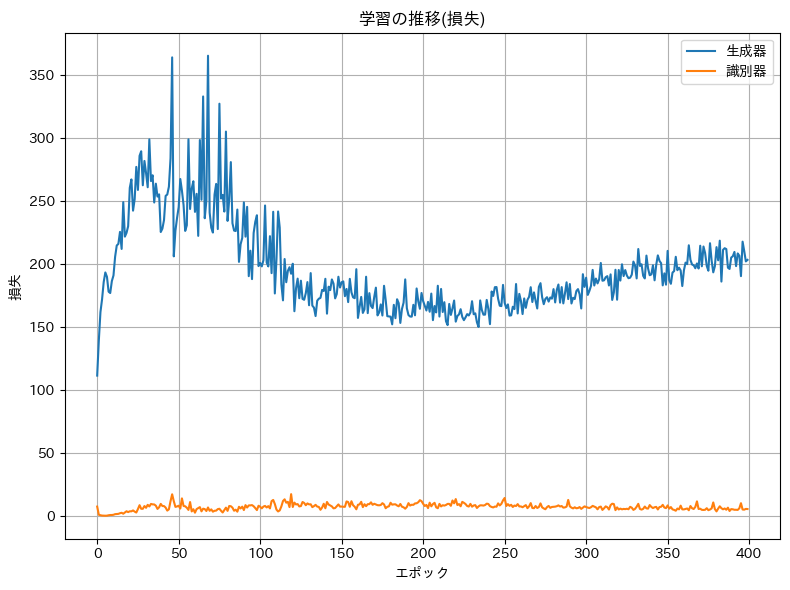

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(G_loss_history, label='生成器')
plt.plot(D_loss_history, label='識別器')
plt.legend()
plt.grid()
plt.title('学習の推移(損失)')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.tight_layout()
save_fig(plt, 'loss')
plt.show()